# Seção 24.03 - Kernel PCA (base census)
Para esta seção, usarei a base de dados "census.csv" disponibilizada no curso do Professor Jones na UDEMY.

In [1]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosts!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Lidar com validação de modelos.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
nomeDaBase = "../bases/census.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

In [3]:
df.head().T

,0,1,2,3,4
age,39,50,38,53,28
workclass,State-gov,Self-emp-not-inc,Private,Private,Private
final-weight,77516,83311,215646,234721,338409
education,Bachelors,Bachelors,HS-grad,11th,Bachelors
education-num,13,13,9,7,13
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife
race,White,White,White,Black,Black
sex,Male,Male,Male,Male,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
final-weight      32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loos      32561 non-null int64
hour-per-week     32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
listaAtributosNumericos = list(df.describe().columns)

In [6]:
dp.cardinalidade(df)

,Atributo,Cardinalidade,Valores
6,sex,2,"[ Male, Female]"
8,income,2,"[ <=50K, >50K]"
5,race,5,"[ White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other]"
4,relationship,6,"[ Not-in-family, Husband, Wife, Own-child, Unmarried, Other-relative]"
2,marital-status,7,"[ Never-married, Married-civ-spouse, Divorced, Married-spouse-absent, Separated, Married-AF-spouse, Widowed]"
0,workclass,9,"[ State-gov, Self-emp-not-inc, Private, Federal-gov, Local-gov, ?, Self-emp-inc, Without-pay, Never-worked]"
3,occupation,15,"[ Adm-clerical, Exec-managerial, Handlers-cleaners, Prof-specialty, Other-service, Sales, Craft-repair, Transport-moving, Farming-fishing, Machine-op-inspct, Tech-support, ?, Protective-serv, Armed-Forces, Priv-house-serv]"
1,education,16,"[ Bachelors, HS-grad, 11th, Masters, 9th, Some-college, Assoc-acdm, Assoc-voc, 7th-8th, Doctorate, Prof-school, 5th-6th, 10th, 1st-4th, Preschool, 12th]"
7,native-country,42,"[ United-States, Cuba, Jamaica, India, ?, Mexico, South, Puerto-Rico, Honduras, England, Canada, Germany, Iran, Philippines, Italy, Poland, Columbia, Cambodia, Thailand, Ecuador, Laos, Taiwan, Haiti, Portugal, Dominican-Republic, El-Salvador, France, Guatemala, China, Japan, Yugoslavia, Peru, Outlying-US(Guam-USVI-etc), Scotland, Trinadad&Tobago, Greece, Nicaragua, Vietnam, Hong, Ireland, Hungary, Holand-Netherlands]"


In [7]:
for i in ["workclass", "occupation", "native-country"]:
    print(df[i].value_counts(),"\n")

 Private             22696
 Self-emp-not-inc    2541 
 Local-gov           2093 
 ?                   1836 
 State-gov           1298 
 Self-emp-inc        1116 
 Federal-gov         960  
 Without-pay         14   
 Never-worked        7    
Name: workclass, dtype: int64 

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing      994 
 Tech-support         928 
 Protective-serv      649 
 Priv-house-serv      149 
 Armed-Forces         9   
Name: occupation, dtype: int64 

 United-States                 29170
 Mexico                        643  
 ?                             583  
 Philippines                   198  
 Germany                       137  
 Canada                        121  
 Puerto-Rico                   114  
 El-Salvador                

### Problemas encontrados na base:

Não foram encontrados problemas na base. Não há valores nulos e nenhum valor incoerente.
**Um ponto de atenção é o valor "?" nos atributos "workclass", "occupation" e "native-country".**
As classes dos atributos categóricos estão com um espaço (*blank space*) antes da palavra.

### Ação:
- Antes de mais nada, preciso remover os espaços a mais.

Nesse momento, devido ao alto volume de registros "?" nos atributos indicados acima, pensei em duas abordagens:
- Plano A) Remover todos os registros que possuem ? em algum dos atributos;
- Plano B) Fazer a "imputação" desses valores usando KNN para estimar a classe a que aquele registro pertence.
Para fins do meu aprendizado, tomarei o plano A inicialmente. Posteriormente, após entender melhor como usar o KNN para imputar dados, farei isso.

#### OBSERVAÇÃO:

No mundo real, os problemas com as bases são muito piores. Deve-se ter muita atenção pois os dados podem não representar a realidade do processo.

## 1) Tratando o df para ser consumido pelo modelo PCA
### Plano A) Remover todos os registros que possuem ? em algum dos atributos:

In [8]:
# Copiando df original para um novo df (df_tratado) e, posteriormente, removendo os registros que possuem classes nulas.

df_tratado = df.copy()

df_obj = df_tratado.select_dtypes(['object'])

df_tratado[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

for i in ["workclass", "occupation", "native-country"]:
    df_tratado[i].replace('?', np.nan, inplace=True)

df_tratado.dropna(how="any", axis=0, inplace=True)

print("Tamanho da base original: {}".format(len(df)))
print("Tamanho da base tratada: {}".format(len(df_tratado)))

Tamanho da base original: 32561
Tamanho da base tratada: 30162


Agora, vamos transformar as variáveis categóricas em numéricas usando o One Hot Encoding:

In [9]:
state_dummies = pd.get_dummies(df_tratado[df_obj.columns], drop_first=True)

df_tratado.drop(df_obj.columns, axis=1, inplace=True)

df_tratado = pd.concat([df_tratado, state_dummies], axis=1)

df_tratado.head().T

,0,1,2,3,4
age,39,50,38,53,28
final-weight,77516,83311,215646,234721,338409
education-num,13,13,9,7,13
capital-gain,2174,0,0,0,0
capital-loos,0,0,0,0,0
hour-per-week,40,13,40,40,40
workclass_Local-gov,0,0,0,0,0
workclass_Private,0,0,1,1,1
workclass_Self-emp-inc,0,0,0,0,0
workclass_Self-emp-not-inc,0,1,0,0,0


## 2) PCA

Antes da aplicação do PCA, precisamos reescalar o valor dos atributos.

In [10]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:-1]
y = df_tratado.iloc[:, -1]

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

**Instanciando o modelo:**

In [13]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=10, kernel="rbf")

## Comparando o desempenho de uma árvore de decisão:

Vamos verificar se há a melhora de desempenho de um modelo de classificação usando o PCA:

**1. Random Forest sem kernel PCA:**

In [14]:
# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:-1]
y = df_tratado.iloc[:, -1]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestClassifier
classificador = RandomForestClassifier(criterion="entropy", max_depth=int(len(x_train[0,:])**0.5))
classificador.fit(x_train, y_train)

y_pred = classificador.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Métrica 1 (Acurácia): 0.844853.
Métrica 2 (Relatório de classificação):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4532
           1       0.78      0.52      0.63      1501

   micro avg       0.84      0.84      0.84      6033
   macro avg       0.82      0.74      0.76      6033
weighted avg       0.84      0.84      0.83      6033
.
Normalized confusion matrix
[[0.95211827 0.04788173]
 [0.47901399 0.52098601]]


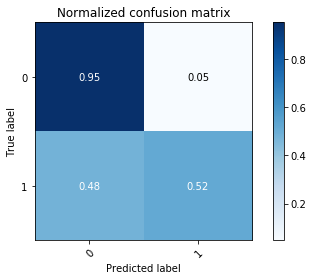

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred)))

plot_confusion_matrix_2(y_test, y_pred, normalize=True);

**2. Random Forest COM kernel PCA:**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

# Separando os fatores/previsores da resposta/target:
    
x = df_tratado.iloc[:, 0:-1]
y = df_tratado.iloc[:, -1]

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = kpca.fit_transform(x_train)
x_test = kpca.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
classificador = RandomForestClassifier(criterion="entropy", max_depth=int(len(x_train[0,:])**0.5))
classificador.fit(x_train, y_train)

y_pred = classificador.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Métrica 1 (Acurácia): {:.6}.".format(
    accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)))
print("Métrica 2 (Relatório de classificação):\n{}.".format(
    classification_report(y_test, y_pred)))

plot_confusion_matrix_2(y_test, y_pred, normalize=True);

# Conclusão da comparação:


**REAVALIAR**
O resultado da classificação após a redução de dimensionalidade, houve a redução das métricas de avaliação de classificação. Porém, um ponto importante que o professor Granatyr pontuou foi que mesmo que haja a redução de uma métrica de avaliação, às vezes você consegue um incremento considerável na execução do algoritmo após a redução de dimensionalidade.